# Shopify - Winter Data Science Intern Challenge

## Question 1

In [14]:
import pandas as pd
import numpy as np
from scipy import stats


In [4]:
df_sneaker = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

In [5]:
df_sneaker.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


#### Statistical analysis of Order value

In [10]:
df_sneaker['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

The statistical analysis of the column `order_amount` suggests that the distribution is highly skewed. The median and quartiles are in the affordable range of sneakers price. However, the mean is extremely high possibly because of some outliers as evident from the range and the max value with extremely high standard deviation.

#### Further analysis of the outlier/max

In [57]:
df_sneaker[df_sneaker['order_amount'] == 704000].head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00


It can be observed that for these max values in the `order_amount` column, the total number of items are extremely high compared to the values closer to median. Also, it is interesting to observe that all these maxima are from the same store ordered at the exact same time each day indicating some wholesale to retail kind of shipment. 

#### Outlier detection using boxplot

<AxesSubplot:>

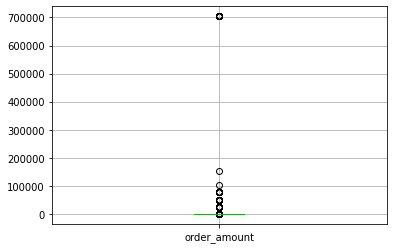

In [61]:
df_sneaker.boxplot(column='order_amount')

It can be observed from the bxoplot that there are a couple of outliers in the `order_amount` column which is leading to the skewness in the distribution and the Average order value (AOV) is incorrectly calculated as $3145.13 which is too high for sneakers

## a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

**Answer**. There are multiple ways of evaluating the dataset and defining a more robust and accurate Average order value

1. **Median**: Median is a more robust point statistic in case of a skewed distribution. So, it is better to use median instead of mean since the data is highly skewed in this case. 

2. **Outlier handling**: The outliers in the dataset can be imputed by the median value or by using any other imputation technique such as regression or knn imputation

3. Unit price: If the unit price of sneaker is important for analysis, it can be calculated from the `order_amount` and `total_items` column and the average value of sneakers sold in the 100 shops can be calculated.

#### Outlier detection

Calculating interquartile range (IQR) and identifying outliers based on IQR since using z-score cannot be used because of the highly skewed distribution

<AxesSubplot:>

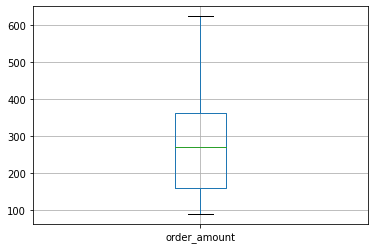

In [60]:
Q1 = df.order_amount.quantile(q=0.25)
Q2 = df.order_amount.quantile(q=0.5)
Q3 = df.order_amount.quantile(q=0.75)
IQR = Q3 - Q1

df_excluding_outliers = df_sneaker[(df_sneaker.order_amount < Q2 + IQR * 1.5) &
                                   (df_sneaker.order_amount > Q2 - IQR * 1.5)]
df_excluding_outliers.boxplot(column='order_amount')

In [62]:
percentage_outliers = (1 - (df_excluding_outliers.shape[0] / df_sneaker.shape[0]))*100
percentage_outliers

5.24

Since the percentage of outliers in the dataset is small (5.24%), therefore it is safe to drop these outliers from the dataset for further analysis

## b. What metric would you report for this dataset?



In [67]:
df_excluding_outliers['order_amount'].mean()

283.81426762346985

In [64]:
df_excluding_outliers['order_amount'].describe()

count    4738.000000
mean      283.814268
std       132.061996
min        90.000000
25%       161.000000
50%       272.000000
75%       362.000000
max       624.000000
Name: order_amount, dtype: float64

It can be observed that the `order_amount` is now skewed towards the lower side. Therefore it is still better to use median as the metric for deciding Average Order Value.

**Answer** The new metric will be the **median** of the column `order_amount`

## c. What is its value?


In [66]:
aov = df_excluding_outliers['order_amount'].median()
aov

272.0

## Question 2

## a. How many orders were shipped by Speedy Express in total?


The Shipper information is available in the Shippers table but it needs to be joined with the Orders table in order to get the number of orders. The table can be filtered for `Speedy Express` after joining and COUNT function can be used to get the total number of orders shipped by Speedy Express.

In [ ]:
SELECT COUNT(*) FROM [Orders] as O
LEFT JOIN [Shippers] as S
ON S.ShipperID = O.ShipperID
WHERE ShipperName = 'Speedy Express';

**Answer**. **54** orders were shipped by Speedy Express in total

## b. What is the last name of the employee with the most orders?


The employee information needs to be extracted from the Employee table whereas the orders information can be extracted from the Orders table. The two tables need to be joined in order to combine the information and groupby for each employee. The number of orders for each employee extracted by using groupby function can then be sorted in the descending order to get the employee with the most orders

In [ ]:
SELECT E.LastName, COUNT(*) as EmpOrders FROM [Orders] as O
JOIN [Employees] as E
ON O.EmployeeID = E.EmployeeID
GROUP BY O.EmployeeID
ORDER BY EmpOrders DESC;

**Answer**. Last name of the employee with highest orders (40) is **Peacock**

## c. What product was ordered the most by customers in Germany?


Country information is available in the Customers table while the Order information can be extracted from the Orders table by joining the two tables and filtering values for Germany.

In order to extract product related information available in the Products table, the Order table must be joined with the OrderDetails table so the ProductID can be referenced and used as foreign key for joining the Product table. After joining the Order and Customer table with the OrderDetails table, the number of products can be calculated by using the sum function on the Quantity field of the OrderDetails table. It should then be sorted in the descending order.

Now, the ProductID needs to be referenced with the Products table in order to get the name of the product which was ordered the most by customers in Germany

**Answer.** **Boston Crab Meat** is the most ordered product by customers in Germany (160 times)